## Import Standard Modules

In [1]:
import math
import time
import numpy as np
from numpy import *
import pandas as pd
import copy
import matplotlib.pyplot as plt
from PIL import Image
import skimage 
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score 
import cv2
from numba import jit
import os
from torch.utils import data
import torch
import torchvision.transforms as transforms

## Define Necessary Functions and Define the Angle Vector Resolution


In [2]:
#define the angle we want to evaluate '>'
angle_srart = 0
angle_end = 20
angle_resolution = (angle_end - angle_srart)*20
angle_increment = (angle_end - angle_srart)/angle_resolution

In [3]:
#set up the max value to normalize the signal
pos_limit = 180
angle_limit = 18


class CustomDataFolder(data.Dataset):
    
    def __init__(self, path, transform = None):
        self._path = path
        self._image_paths = os.listdir(path)
        self._transform = transform
        
    def __getitem__(self, index):
        image = Image.open(os.path.join(self._path, self._image_paths[index]))
        label0 = os.path.basename(self._image_paths[index]).split('_')[1]
        label1 = float(os.path.basename(self._image_paths[index]).split('_')[2])/100/pos_limit
        label2 = float((os.path.basename(self._image_paths[index]).split('_')[3]).split('.')[0])/1000/angle_limit
        #label3 = int(label2*angle_resolution + angle_srart)
        #print(label)
        if self._transform:
            image = self._transform(image)
        #return image, label1, label2, label0, label3
        return image, label1, label2, label0
    
    def __len__(self):
        return len(self._image_paths)

In [4]:
#set up cuda OR cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [5]:
#You may need to find the dir of your images in terminal and enter 'rm .DS_Store' and enter enter(return)
#For my case, it is: (base) Xs-MacBook-Pro:data_augment2 xbao$ rm .DS_Store

#transform the data to tensor so that you can use pytorch
transform = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.ToTensor()
])

trainset = CustomDataFolder('../data_augment2', transform)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:136: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


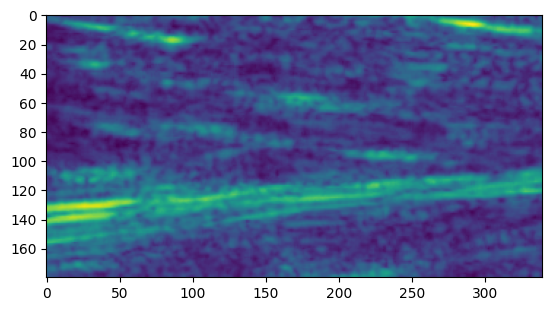

In [6]:
#show an example of your data
#trainset[0][0] is the image
#trainset[0][1] is the vertical position, trainset[0][2] is the angle

tensor_exam = trainset[1000][0]
pic_exam = tensor_exam.cpu().numpy()
pic_exam_1 = pic_exam[0]

pos_exam = trainset[1000][1]*180
angle_exam = trainset[1000][2]*18

plt.imshow(pic_exam_1)

In [7]:
#erase the pixles whose values are less than an intensity
def denoising2(image, intensity):
    image_new = np.zeros(image.shape)
    for x in range(0, image.shape[0]):
        for y in range(0, image.shape[1]):
            if image[x, y] >= intensity:
                image_new[x, y] = image[x, y]
    return image_new


#@jit(nopython=True)
def kill_apo(img, height_rate, angle_resolution):
    #output of the hough transform doesn't match the image coordinate 
    xmax = img.shape[0]
    ymax = img.shape[1]
    
    x0 = int(height_rate*xmax)
    
    a0 = 0
    at = 20
    
    img_no_apo = img
    value_map = np.zeros((xmax, at))
    
    
    for x in range(x0, xmax):
        for a in range(a0, at, angle_resolution):
            pixel_accum = 0
            for y in reversed(range(0, ymax)):
              
                dx = (ymax-y)*math.tan(a*pi/180)
                #print(dx, a)
                xi = int(x + dx)
               
                if xi >= xmax:
                    break
                #print(xi, y, x, a)
                if img[xi][y] > 0.1:
                    pixel_accum = pixel_accum + img[xi][y]
                
            if pixel_accum > 100:
                value_map[x][a] = 1
    
    for x in range(x0, xmax):
        for a in range(a0, at, angle_resolution):
            
            if value_map[x][a] > 0.9:
            
                for y in reversed(range(0, ymax)):
                    dx = (ymax-y)*math.tan(a*pi/180)
                    #print(dx, a)
                    xi = int(x + dx)

                    if xi >= xmax:
                        break
                    #print(xi, y, x, a)
                    img_no_apo[xi][y] = 0
                        

    
    return img_no_apo

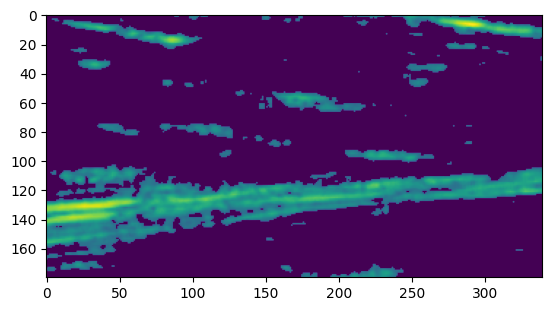

In [8]:
pic_exam_1_clear = denoising2(pic_exam_1, 0.25)
plt.imshow(pic_exam_1_clear)

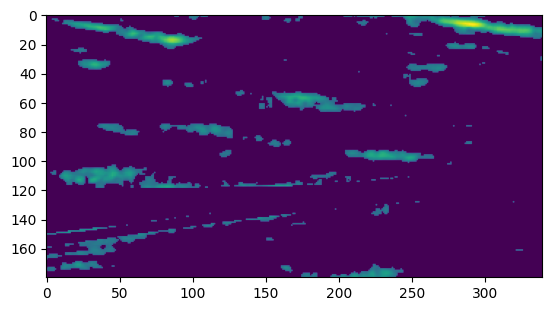

In [9]:
img_no_apo = kill_apo(pic_exam_1_clear, 0.5, 1)
plt.imshow(img_no_apo)

In [10]:
@jit(nopython=True)
def accum_value7(img, xc, yc, angle):
    #output of the hough transform doesn't match the image coordinate 
    xmax = img.shape[0]
    ymax = img.shape[1]
    
    if angle == 0:
        angle = 0.000000000001

    xl = int(yc*math.tan(angle*pi/180))
    yl = int(xc/math.tan(angle*pi/180))
    
    if yc - yl > 0:
        x0 = 0
        y0 = yc - yl
    else:
        x0 = xc - xl
        y0 = 0
       
    
    value = 0
    dis_weight = 0
    pixel_accum = 0
    #accumulate the value
    for y in range(y0, ymax):
        x = x0 + y*math.tan(angle*pi/180) 
        x = int(x)
        if x<0 or x>=xmax or y<0 or y>=ymax: break
            
               
        value = value + img[x][y]/ymax

        if img[x][y] > 0.01:
            pixel_accum = pixel_accum + img[x][y]
        else:
            pixel_accum = 0

        dis_weight = dis_weight + math.tanh(0.01*pixel_accum)
        #print(x, dis_weight)
        
    dis_weight_norm = math.tanh(0.2*dis_weight)

    #print(dis_weight_norm)

    return value * dis_weight_norm


In [11]:
@jit(nopython=True)
def accum_value8(img, xc, yc, angle):
    #output of the hough transform doesn't match the image coordinate 
    xmax = img.shape[0]
    ymax = img.shape[1]
    
    if angle == 0:
        angle = 0.000000000001

    xl = int(yc*math.tan(angle*pi/180))
    yl = int(xc/math.tan(angle*pi/180))
    
    if yc - yl > 0:
        x0 = 0
        y0 = yc - yl
    else:
        x0 = xc - xl
        y0 = 0
       
    
    value = 0
    dis_weight = 1
    pixel_accum = 0
    #accumulate the value
    for y in range(y0, ymax):
        x = x0 + y*math.tan(angle*pi/180) 
        x = int(x)
        if x<0 or x>=xmax or y<0 or y>=ymax: break
            
               
        value = value + img[x][y]/ymax

        if img[x][y] > 0.01:
            pixel_accum = pixel_accum + 1
        else:
            pixel_accum = 0

        dis_weight =  dis_weight*math.exp(0.005*pixel_accum)
        #print(x, dis_weight)
        
    dis_weight_norm = math.tanh(0.00025*dis_weight)

    #print(dis_weight_norm)

    return value * dis_weight_norm


In [12]:
#x is vertical axis; y is horizontal axis
x_size = pic_exam_1.shape[0]
y_size = pic_exam_1.shape[1]


y_center = 77 #this is set up already when we extract the reference


x_start = int(x_size * 0.0)
x_end = int(x_size * 1.0)

#create a new image
r_dim = x_size
theta_dim = angle_resolution
image_hough = np.zeros((r_dim, theta_dim))

pic_exam_1_temp = copy.deepcopy(pic_exam_1)
pic_exam_1_clear = denoising2(pic_exam_1_temp, 0.20)
pic_exam_1_clear_temp =  copy.deepcopy(pic_exam_1_clear)
img_no_apo = kill_apo(pic_exam_1_clear_temp, 0.5, 1)

img_use = pic_exam_1
#img_use = pic_exam_1_clear
#img_use = img_no_apo

for x in range(x_start, x_end):
    for a in range(angle_resolution):
        #print(angle_srart + a*angle_increment)
        angle = angle_srart + a*angle_increment
        value= accum_value7(img_use, x, y_center, angle)
        image_hough[x][a] = value

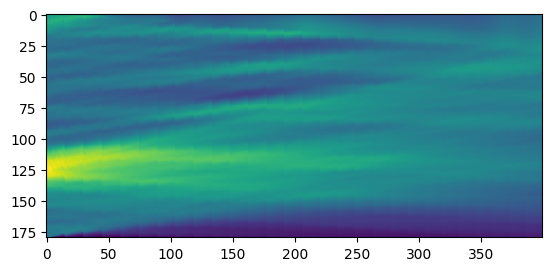

In [13]:
plt.imshow(image_hough)

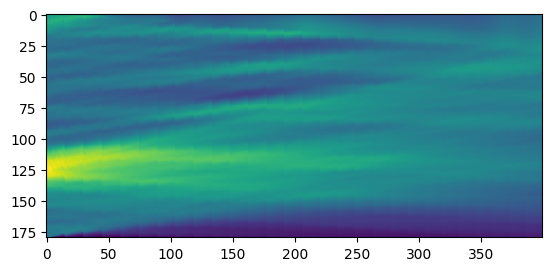

In [14]:
centerOfCircle = (int(angle_exam/angle_limit * angle_resolution + angle_srart), int(pos_exam))
image_label = cv2.circle(image_hough, centerOfCircle, radius = 5, color = [0.2,0.1,0.0], thickness = 1)
plt.imshow(image_label)

In [ ]:
time_vec = []

for n in range (8557):
    tensor_n = trainset[n][0]
    pic = tensor_n.cpu().numpy()
    pic1 = pic[0]
    
    #create a new image
    r_dim = x_size
    theta_dim = angle_resolution
    image_hough = np.zeros((r_dim, theta_dim)) 
    
    if trainset[n][2] < 0:
        continue

    start_time = time.time()

    pic1_clear = denoising2(pic1, 0.20)
    img_no_apo = kill_apo(pic1_clear, 0.5, 1)

    for x in range(x_start, x_end):
        for a in range(angle_resolution):
            angle = angle_srart + a*angle_increment
            value= accum_value7(img_no_apo, x, y_center, angle)
            image_hough[x][a] = value  
    #plt.imsave('../data_augment_weight_dist_no_apo_ct/AnkleHough_' + str(trainset[n][3]) + '_' + str(int(trainset[n][1]*10000)) + '_' + str(int(trainset[n][2]*10000)) + '.jpg', image_hough) 


    end_time = time.time()
    time_running = end_time - start_time
    print('Running Time', time_running)
    time_vec.append(time_running)

    

In [17]:
mean(time_vec), max(time_vec), min(time_vec)

(1.230874478816986, 1.5488426685333252, 1.177983045578003)

In [56]:
minvalue = 100
maxvalue = -100

for i in range (8557):
    tempvalue = trainset[i][2]
    if tempvalue > maxvalue:
        maxvalue = tempvalue
    if tempvalue < minvalue:
        minvalue = tempvalue


In [60]:
minvalue*18

-1.1457

In [61]:
maxvalue*18

17.7879

In [168]:
math.exp(0.01*50)

1.6487212707001282

In [179]:
image_hough

array([[0.14393998, 0.14393998, 0.14393998, ..., 0.06673367, 0.06910228,
        0.07067208],
       [0.14260198, 0.14260198, 0.14260198, ..., 0.06675583, 0.06912517,
        0.07069538],
       [0.12796159, 0.12796159, 0.12796159, ..., 0.06678746, 0.06915786,
        0.07072865],
       ...,
       [0.06473813, 0.06473813, 0.06473813, ..., 0.02820006, 0.02802422,
        0.02802422],
       [0.07429184, 0.07429184, 0.07429184, ..., 0.02560059, 0.02553453,
        0.02535947],
       [0.07111143, 0.07111143, 0.07111143, ..., 0.02439538, 0.02427409,
        0.02427409]])